C:\Users\stoib\AppData\Local\Temp\ipykernel_37424\3965217633.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_acc, x='Model', y='Accuracy', palette=['#ff7f0e', '#1f77b4'], ax=ax_a)
C:\Users\stoib\AppData\Local\Temp\ipykernel_37424\3965217633.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recall_df, x='Model', y='Recall', palette=['#ff7f0e', '#1f77b4'], ax=ax_b)


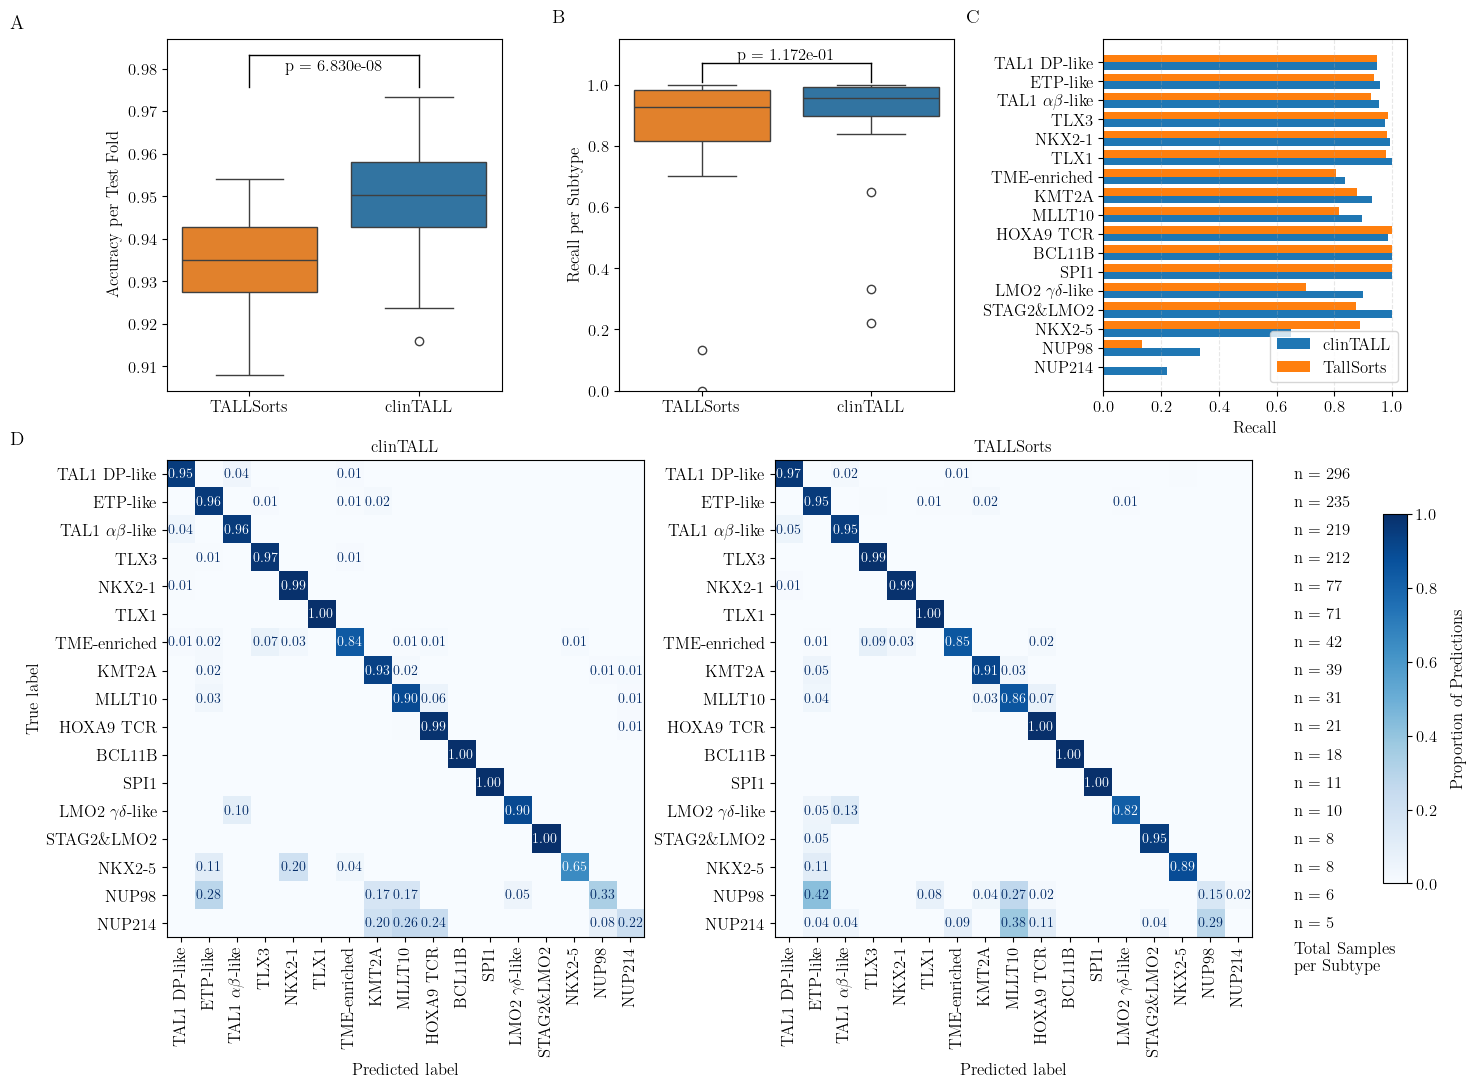

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

clinTall = pd.read_csv('benchmark/classification_report_clintall_aggregated.tsv', index_col=0, sep='\t')
Tallsorts = pd.read_csv('benchmark/classification_report_tallsorts_aggregated.tsv', index_col=0, sep='\t')

# === First, compute the sorted labels from Panel D data (by sample count) ===
clintall_preds = pd.read_csv('benchmark/all_probabilities.csv', index_col=0).drop(columns=["fold", "run"])
clintall_labels = pd.read_csv('benchmark/all_true_labels.csv', index_col=0).drop(columns=["fold", "run"])

raw_labels_ct = clintall_labels.columns
cm_raw_ct = confusion_matrix(clintall_labels.values.argmax(axis=1), clintall_preds.values.argmax(axis=1))

cmdf_ct = pd.DataFrame(cm_raw_ct, index=raw_labels_ct, columns=raw_labels_ct)
cmdf_ct['Total'] = cmdf_ct.sum(axis=1)
cmdf_ct = cmdf_ct.sort_values(by='Total', ascending=False)
totals = cmdf_ct['Total'].to_list().copy()
sorted_labels_ct = cmdf_ct.index.to_list()  # This is the order by sample count

# === Create Figure ===
fig = plt.figure(figsize=(16, 12))
gs_main = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5], hspace=0.1)

# Row 0: Panels A, B, and C
gs_row0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[0], wspace=0.35,
                                            width_ratios=[1, 1, 1])

# Row 1: Panel D (confusion matrices)
gs_row1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[1], wspace=0.4, 
                                            width_ratios=[1, 1, 0.05])

# === Panel A: Accuracy Boxplot ===
ax_a = fig.add_subplot(gs_row0[0])

fold_metrics = pd.read_csv('benchmark/fold_metrics_tallsorts.csv', index_col=0)
fold_metrics2 = pd.read_csv('benchmark/fold_metrics_clintall.csv', index_col=0)
accuracy_ts = fold_metrics.index.tolist()
accuracy_ct = fold_metrics2.accuracy.tolist()
data_acc = {'Accuracy': accuracy_ts + accuracy_ct,
            'Model': ['TALLSorts'] * len(accuracy_ts) + ['clinTALL'] * len(accuracy_ct)}
df_acc = pd.DataFrame(data_acc)

sns.boxplot(data=df_acc, x='Model', y='Accuracy', palette=['#ff7f0e', '#1f77b4'], ax=ax_a)
t_stat, p_value_a = ttest_rel(accuracy_ts, accuracy_ct)

# Add bracket and p-value
max_acc = max(df_acc['Accuracy'])
ax_a.plot([0, 1], [max_acc + 0.01, max_acc + 0.01], color='black', lw=1)
ax_a.plot([0, 0], [max_acc + 0.0025, max_acc + 0.01], color='black', lw=1)
ax_a.plot([1, 1], [max_acc + 0.0025, max_acc + 0.01], color='black', lw=1)
ax_a.text(0.5, 0.92, f'p = {p_value_a:.3e}', ha='center', va='center', transform=ax_a.transAxes)
ax_a.set_xlabel('')
ax_a.set_ylabel('Accuracy per Test Fold')

#fig.text(0.02, 0.97, 'A', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel B: Recall Boxplot ===
ax_b = fig.add_subplot(gs_row0[1])

metric = 'recall'
# Reindex to match the sorted order from Panel D
clinTall_subtypes_sorted = clinTall.loc[sorted_labels_ct]
Tallsorts_subtypes_sorted = Tallsorts.loc[sorted_labels_ct]

clinTall_subtypes_recalls = clinTall_subtypes_sorted[metric]
Tallsorts_subtypes_recalls = Tallsorts_subtypes_sorted[metric]

data_recall = {
    'Recall':  list(Tallsorts_subtypes_recalls) + list(clinTall_subtypes_recalls),
    'Model': ['TALLSorts'] * len(sorted_labels_ct) + ['clinTALL'] * len(sorted_labels_ct) 
}
recall_df = pd.DataFrame(data_recall)

sns.boxplot(data=recall_df, x='Model', y='Recall', palette=['#ff7f0e', '#1f77b4'], ax=ax_b)
t_stat, p_value_b = ttest_rel(Tallsorts_subtypes_recalls, clinTall_subtypes_recalls)

max_recall = max(data_recall['Recall'])
ax_b.plot([0, 1], [max_recall + 0.07, max_recall + 0.07], color='black', lw=1)
ax_b.plot([0, 0], [max_recall + 0.01, max_recall + 0.07], color='black', lw=1)
ax_b.plot([1, 1], [max_recall + 0.01, max_recall + 0.07], color='black', lw=1)
ax_b.text(0.5, 0.95, f'p = {p_value_b:.3e}', ha='center', va='center', transform=ax_b.transAxes)
ax_b.set_xlabel('')
ax_b.set_ylabel('Recall per Subtype')
ax_b.set_ylim(0, 1.15)

#fig.text(0.35, 0.97, 'B', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel C: Recall Comparison Bar Chart (ordered by sample count) ===
ax_c = fig.add_subplot(gs_row0[2])

# Use the sorted order from Panel D
plot_labels = [label.replace('γ', r'$\gamma$').replace('δ', r'$\delta$').replace('α', r'$\alpha$').replace('β', r'$\beta$').replace('&', r'\&') for label in sorted_labels_ct]

x = np.arange(len(sorted_labels_ct))
width = 0.4

ax_c.barh(x - width/2, clinTall_subtypes_sorted['recall'][::-1], width, label='clinTALL', color='#1f77b4')
ax_c.barh(x + width/2, Tallsorts_subtypes_sorted['recall'][::-1], width, label='TallSorts', color='#ff7f0e')

ax_c.set_xlabel('Recall')
#ax_c.set_ylabel('Subtype')
ax_c.set_yticks(x)
ax_c.set_yticklabels(plot_labels[::-1])
ax_c.set_xlim(0, 1.05)
ax_c.legend(loc='lower right')
ax_c.grid(True, alpha=0.3, axis='x', linestyle='--')
pos_c = ax_c.get_position()
ax_c.set_position([pos_c.x0 + 0.02, pos_c.y0, pos_c.width - 0.02, pos_c.height])

#fig.text(0.62, 0.97, 'C', fontweight='bold', fontsize=14, va='top', ha='left')

# === Panel D: Confusion Matrices ===
ax_d1 = fig.add_subplot(gs_row1[0])
ax_d2 = fig.add_subplot(gs_row1[1])
ax_cbar = fig.add_subplot(gs_row1[2])

# Normalize clinTALL confusion matrix
cmdf_ct = cmdf_ct.drop(columns=['Total'])[sorted_labels_ct]
cmdf_ct = cmdf_ct.div(cmdf_ct.sum(axis=1), axis=0)
cm_ct = cmdf_ct.values

plot_labels_ct = [label.replace('γ', r'$\gamma$').replace('δ', r'$\delta$').replace('α', r'$\alpha$').replace('β', r'$\beta$').replace('&', r'\&') for label in sorted_labels_ct]

# Prepare TallSorts Data
cfm_ts = pd.read_csv('benchmark/confusion_matrix_tallsorts.csv', index_col=0)
cfm_ts = cfm_ts[sorted_labels_ct].loc[sorted_labels_ct, :]
cfm_ts = cfm_ts.div(cfm_ts.sum(axis=1), axis=0)
cm_ts = cfm_ts.values

# Plot confusion matrices
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_ct, display_labels=plot_labels_ct)
disp1.plot(cmap='Blues', ax=ax_d1, xticks_rotation='vertical', colorbar=False, values_format='.2f',  text_kw={'fontsize': 10})
ax_d1.set_title('clinTALL', fontsize=12, fontweight='bold')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_ts, display_labels=plot_labels_ct)
disp2.plot(cmap='Blues', ax=ax_d2, xticks_rotation='vertical', colorbar=False, values_format='.2f',  text_kw={'fontsize': 10})
ax_d2.set_title('TALLSorts', fontsize=12, fontweight='bold')
ax_d2.set_ylabel('')

# Remove 0.00 annotations
for text in disp1.text_.ravel():
    if text.get_text() == '0.00':
        text.set_text('')
for text in disp2.text_.ravel():
    if text.get_text() == '0.00':
        text.set_text('')

# Add colorbar
fig.colorbar(disp2.im_, cax=ax_cbar, fraction=0.75)
#make colorbar smaller
ax_cbar.set_ylabel('Proportion of Predictions', rotation=90, labelpad=10)
# Shrink colorbar height
pos = ax_cbar.get_position()
new_height = pos.height * 0.7  # Reduce to 70% of original height
new_y0 = pos.y0 + (pos.height - new_height) / 2  # Center it vertically
ax_cbar.set_position([pos.x0, new_y0, pos.width, new_height])

# Annotate total counts
for i, total in enumerate([t/10 for t in totals]):
    ax_d2.text(18, (i) , f'n = {int(total)}', va='center', fontsize=12)
ax_d2.text(18, i+1.25 , 'Total Samples \n per Subtype', va='center', ha='left', 
           fontsize=12, fontweight='bold')

#fig.text(0.02, 0.48, 'D', fontweight='bold', fontsize=14, va='top', ha='left')

pos_a = ax_a.get_position()
pos_b = ax_b.get_position()
pos_c = ax_c.get_position()
pos_d = ax_d1.get_position()
pos_d2 = ax_d2.get_position()
first_col_x = pos_d.x0 - 0.075
#fig.text(first_col_x, pos_a.y1 + 0.02, 'A', fontweight='bold', fontsize=14, va='top', ha='left')
#fig.text(pos_b.x0 - 0.04, pos_b.y1 + 0.02, 'B', fontweight='bold', fontsize=14, va='top', ha='left')
#fig.text(pos_c.x0 - 0.08, pos_c.y1 + 0.02, 'C', fontweight='bold', fontsize=14, va='top', ha='left')
#fig.text(first_col_x, pos_d.y1 + 0.02, 'D', fontweight='bold', fontsize=14, va='top', ha='left')
#fig.text(pos_d2.x0 - 0.02, pos_d2.y1 + 0.01, 'E', fontweight='bold', fontsize=14, va='top', ha='left')

def label_panel(fig, ax, label, dx=0.0, dy=0.01):
    bbox = ax.get_position()
    fig.text(
        bbox.x0 + dx,
        bbox.y1 + dy,
        label,
        fontweight='bold',
        fontsize=14,
        va='bottom',
        ha='left'
    )

#label_panel(fig, ax_a, 'A')
#label_panel(fig, ax_b, 'B')
#label_panel(fig, ax_c, 'C')
#label_panel(fig, ax_d1, 'D')

def label_panel_left_of_yticks(fig, ax, label, dy=0.01, pad=0.01):
    fig.canvas.draw()  # ensure text positions are computed

    # Get all y tick labels
    ticklabels = ax.get_yticklabels()
    ticklabels = [t for t in ticklabels if t.get_text() != '']

    if not ticklabels:
        # fallback to axes left if no tick labels
        x = ax.get_position().x0
    else:
        # union of all ytick label bounding boxes
        renderer = fig.canvas.get_renderer()
        bboxes = [t.get_window_extent(renderer) for t in ticklabels]
        bbox = bboxes[0].union(bboxes)

        # convert from display to figure coordinates
        bbox_fig = bbox.transformed(fig.transFigure.inverted())
        x = bbox_fig.x0 - pad  # slightly left of label text

    y = ax.get_position().y1 + dy

    fig.text(
        x, y, label,
        fontweight='bold',
        fontsize=14,
        color='black',
        ha='left',
        va='bottom'
    )

#label_panel_left_of_yticks(fig, ax_a, 'A')
#label_panel_left_of_yticks(fig, ax_b, 'B')
label_panel_left_of_yticks(fig, ax_c, 'C')
#label_panel_left_of_yticks(fig, ax_d1, 'D')

def label_panel_left_of_ylabel(fig, ax, label, dy=0.01, pad=0.01):
    fig.canvas.draw()  # ensure renderer exists

    ylabel = ax.yaxis.get_label()

    # If no y-label is set, fall back to axes position
    if ylabel.get_text() == '':
        x = ax.get_position().x0
    else:
        renderer = fig.canvas.get_renderer()
        bbox = ylabel.get_window_extent(renderer=renderer)

        # Convert display → figure coordinates
        bbox_fig = bbox.transformed(fig.transFigure.inverted())

        # Leftmost edge of the y-label text
        x = bbox_fig.x0 - pad

    y = ax.get_position().y1 + dy

    fig.text(
        x, y, label,
        fontsize=14,
        fontweight='bold',
        color='black',
        ha='left',
        va='bottom'
    )
    return x, y

#label_panel_left_of_ylabel(fig, ax_a, 'A')
_,y=label_panel_left_of_ylabel(fig, ax_b, 'B')
#label_panel_left_of_ylabel(fig, ax_c, 'C')
x,_=label_panel_left_of_ylabel(fig, ax_d1, 'D')

pos_d = ax_d1.get_position()
pos_d2 = ax_d2.get_position()
first_col_x = pos_d.x0 - 0.075
fig.text(x, pos_a.y1 + 0.02, 'A', fontweight='bold', fontsize=14, va='top', ha='left')

plt.savefig('figure3_multipanel.pdf', dpi=600, bbox_inches='tight')
plt.show()